## Import Tensorflow and enable eager execution

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output

## Load the dataset

apply random jittering and mirroring to the training dataset.

- in random jittering, the image is resized to 286x286 and then randomly cropped to 256x256
- in random mirroring, the image is randomly flipped horizontally, i.e left to right.

In [2]:
# Downloads a file from a URL if it not already in the cache.
# Returns: Path to the downloaded file
path_to_zip = tf.keras.utils.get_file(fname='facades.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz', 
                                      extract=True)
# path_to_zip에는 파일 이름까지 포함되어 있다. 
# os.path.dirname으로 파일 이름은 지우고 디렉토리만 남긴다.
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [3]:
path_to_zip

'D:\\PythonLab\\CS20\\pix2pix\\facades.tar.gz'

In [4]:
os.path.dirname(path_to_zip)

'D:\\PythonLab\\CS20\\pix2pix'

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

Show and Tell 모델에서 이미지 처리 방식
```python
# encoded_image는 placeholder로 읽혀지는 TFRecodes 파일(Gfile로 f.read함)
image = tf.image.decode_jpeg(contents=encoded_image, channels=3)
image = tf.image.resize_images(image,size=[resize_height, resize_width],
                               method=tf.image.ResizeMethod.BILINEAR)
if is_training:
        image = tf.random_crop(image, [height, width, 3])
    # eval과정이라면 정중앙으로 crop한다.    
else:
        image = tf.image.resize_image_with_crop_or_pad(image, height, width)
image = tf.subtract(image, 0.5)
image = tf.multiply(image, 2.0)
```

In [6]:
from PIL import Image
image = Image.open(PATH+'train/1.jpg').convert('RGB')

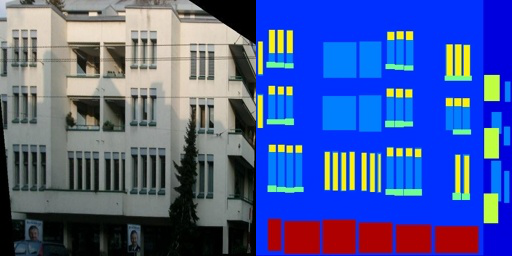

In [7]:
image

In [8]:
def load_image(image_file, is_train):
    # Return : A `Tensor` of type `string`
    image = tf.read_file(image_file)
    # Decode a JPEG-encoded image to a uint8 tensor.
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]

    # 인풋 데이터의 architecture label과 photo가 한 이미지에 합쳐져 있다.
    # width의 절반으로 구분할 수 있다.
    w = w //2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    # uint8 텐서 -> float32텐서로 바꾼다.
    input_image = tf.cast(input_image, tf.float32)
    real_image =  tf.cast(real_image, tf.float32)
    
    # 만약 학습 단계라면 random jittering과 mirroring을 수행한다.
    if is_train:
        # align_corners: bool.  If True, the centers of the 4 corner pixels of the
        # input and output tensors are aligned, preserving the values at the
        # corner pixels
        input_image = tf.image.resize_images(input_image, [286, 286],align_corners=True,
                                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        real_image = tf.image.resize_images(real_image, [286, 286], align_corners=True,
                                           method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # randomly cropping to 256x256x3 
        # Given a list of length `N` of tensors of shape `(A, B, C)
        # if `axis == 0` then the `output` tensor will have the shape `(N, A, B, C)
        stacked_image = tf.stack([input_image, real_image], axis=0)
        cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
        input_image, real_image = cropped_image[0], cropped_image[1]
        
        if np.random.random() > 0.5:
            # radom mirroring
            input_image = tf.image.flip_left_right(input_image)
            real_image = tf.image.flip_left_right(real_image)
    # train이 아니라면 단순히 resize만 하도록 한다.        
    else:
        input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH],
                                            align_corners=True, method=tf.image.ResizeMethod.BICUBIC)
        real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH],
                                            align_corners=True, method=tf.image.ResizeMethod.BICUBIC)
        
    # normalizing the images to [-1,1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

## Use tf.data to create batches, map(do preprocessing) and shuffle the dataset

In [9]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(1)

In [30]:
train_dataset

<BatchDataset shapes: ((?, 256, 256, 3), (?, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [10]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(1)

## Write the generator and discriminator models

- Ck는 Conv-BatchNorm-Relu 레이어를 k개 필터로 나타낸다
- CDk는 Convolution-BatchNorm-Dropout-Relu를 50% dropout
- 모든 convolution은 4x4 spatial filter를 stride 2와 함께 사용한다



- Generator : 
    - encoder: C64-C128-C256-C512-C512-C512-C512-C512
    - decoder: CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128
    - 인코더의 첫번째 C64 레이어에선 BatchNorm이 적용되지 않는다
    - 디코더의 마지막 레이어 후에 conv가 하나 적용되어서 아웃풋 채널 수로 매핑되고 tanh가 따라나온다
    
- Discriminator:
    - C64-C128-C256-C512
    - 처음 C64 레이어에는 BatchNorm이 적용되지 않았다
    - 마지막 레이어 후에는 conv가 하나 적용되어 1 차원 아웃풋으로 매핑하고 이 다음으로 sigmoid가 나온다.
    - The shape of the output after the last layer is (batch_size, 30, 30, 1)
    - Each 30x30 patch of the output classifies a 70x70 portion of the input image
    - Discriminator receives 2 inputs.
        - Input image and the target image, which it should classify as real.
        - Input image and the generated image (output of generator), which it should classify as fake.
        - We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

In [11]:
OUTPUT_CHANNELS = 3

tf.keras.Model은 레이어를 객체안에 그룹짓게 해준다.

두 가지 방법으로 Model 객체를 만들 수 있다.

- functional API 형태로 만든다.

```python
def final_model(input_dim, filters, kernel_size, conv_stride, conv_border_mode, units, dilation,output_dim=29):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # TODO: Specify the layers in your network
    conv1d_1 = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d_1', dilation_rate=dilation)(input_data)
    conv1d_1 = MaxPooling1D(pool_size=2, strides=2, name='max_pool')(conv1d_1)
    bn_cnn = BatchNormalization(name='bn_conv_1d_1')(conv1d_1)
    
    # Add recurrent layers
    simp_rnn = Bidirectional(SimpleRNN(units, activation='relu',
        return_sequences=True, implementation=2, name='rnn_1', dropout=0.3),merge_mode='concat')(bn_cnn)
    bn_rnn = BatchNormalization()(simp_rnn)
    
    simp_rnn = Bidirectional(SimpleRNN(units, activation='relu',
        return_sequences=True, implementation=2, name='rnn_2', dropout=0.4), merge_mode='concat')(bn_rnn)
    bn_rnn = BatchNormalization()(simp_rnn)
    
    
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # TODO: Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # TODO: Specify model.output_length
    
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride, dilation)//2
    print('model.output_length', model.output_length)
    print(model.summary())
    return model
```

- Model을 상속한다. `__init__`에는 레이어를 정의하고 `call`에는 forward pass를 정의한다. 이 경우에는 `call`에서 `training` argument를 써서 training과 inference에 다르게 동작하게 만들 수 있다.

In [12]:
class Downsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.conv1 = tf.keras.layers.Conv2D(filters, (size,size), strides=2, padding='same',
                                           kernel_initializer=initializer, use_bias=False)
        
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
            
    def call(self, x, training):
        x = self.conv1(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x
        

In [13]:
class Upsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_dropout=False):
        super(Upsample,self).__init__()
        self.apply_dropout = apply_dropout
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.up_conv = tf.keras.layers.Conv2DTranspose(filters, (size,size), strides=2, padding='same',
                                                      kernel_initializer=initializer,use_bias=False)
        
        self.batchnorm = tf.keras.layers.BatchNormalization()
        if self.apply_dropout:
            self.dropout = tf.keras.layers.Dropout(0.5)
    
    # x2는 skip-connection으로 i번째 Downsample이 n-i번째 Downsample과 연결된다.
    def call(self, x1, x2, training):
        x = self.up_conv(x1)
        x = self.batchnorm(x, training=training)
        if self.apply_dropout:
            x = self.dropout(x, training=training)
          
        x = tf.nn.relu(x)
        # 필터수를 기준으로 concat
        x = tf.concat([x, x2], axis=-1)
        
        return x

In [53]:
class Generator(tf.keras.Model):
    
    def __init__(self):
        super(Generator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        
        # encoder
        self.down1 = Downsample(64, 4, apply_batchnorm=False)
        self.down2 = Downsample(128, 4)
        self.down3 = Downsample(256, 4)
        self.down4 = Downsample(512, 4)
        self.down5 = Downsample(512, 4)
        self.down6 = Downsample(512, 4)
        self.down7 = Downsample(512, 4)
        # bottleneck
        self.down8 = Downsample(512, 4)
        
        # decoder
        self.up1 = Upsample(512, 4, apply_dropout=True)
        self.up2 = Upsample(512, 4, apply_dropout=True)
        self.up3 = Upsample(512, 4, apply_dropout=True)
        self.up4 = Upsample(512, 4)
        self.up5 = Upsample(256, 4)
        self.up6 = Upsample(128, 4)
        self.up7 = Upsample(64, 4)
        
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, (4,4), strides=2, padding='same',
                                                   kernel_initializer=initializer)
        
    @tf.contrib.eager.defun
    def call(self, x, training):
        # x shape = [batch, 256, 256, 3]
        # Encoder
        x1 = self.down1(x, training=training) # (bs, 128,128,64)
        x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
        x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
        x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
        x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
        x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
        x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
        # Bottleneck
        x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

        # Decoder
        x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
        x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
        x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
        x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
        x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
        x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
        x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

        x16 = self.last(x15) # (bs, 256, 256, 3)
        x16 = tf.nn.tanh(x16)

        return x16

In [54]:
class DiscDownsample(tf.keras.Model):
    
    def __init__(self, filters, size, apply_batchnorm=True):
        super(DiscDownsample, self).__init__()
        self.apply_batchnorm = apply_batchnorm
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.conv1 = tf.keras.layers.Conv2D(filters,
                                           (size, size),
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           use_bias=False)
        
        if self.apply_batchnorm:
            self.batchnorm = tf.keras.layers.BatchNormalization()
            
    def call(self, x, training):
        x = self.conv1(x)
        if self.apply_batchnorm:
            x = self.batchnorm(x, training=training)
        x = tf.nn.leaky_relu(x)
        return x
            

padding='SAME' : ceil(float(H_in))/float(S)

padding='VALID' : ceil(float(H_in - F + 1) / float(S))

In [55]:
class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        
        self.down1 = DiscDownsample(64, 4, False)
        self.down2 = DiscDownsample(128, 4)
        self.down3 = DiscDownsample(256, 4)
        
        # conv를 앞으로 2개 더 적용할텐데 마지막은 channel=1이고 이번에 할 것은 channel=512이다.
        # 두 번의 conv만으로 30x30 patch를 만들어야 하기 때문에 padding을 붙혀서 맞추어주자.
        # (bs, 32, 32, 256)을  (bs, 31, 31, 512)으로 만들기 위한 패딩
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 
                                          (4,4),
                                          strides=1,
                                          kernel_initializer=initializer,
                                          use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        
        # (bs, 31, 31, 512)를 (bs, 30,30,1)으로 만들기 위한 패딩
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1,
                                          (4,4),
                                          strides=1,
                                          kernel_initializer=initializer)
        
    @tf.contrib.eager.defun
    def call(self, inp, tar, training):
        # 인풋과 타겟을 concat한다 (cGAN)
        x = tf.concat([inp, tar], axis=-1) # (bs, 256, 256, channels*2)
        x = self.down1(x, training=training) # (bs, 128, 128, 64)
        x = self.down2(x, training=training) # (bs, 64, 64, 128)
        x = self.down3(x, training=training) # (bs, 32, 32, 256)
        
        x = self.zero_pad1(x) # (bs, 34, 34, 256)
        x = self.conv(x)      # (bs, 31, 31, 512)
        x = self.batchnorm1(x, training=training)
        x = tf.nn.leaky_relu(x)
        
        # loss함수가 raw logits를 받으므로 sigmoid를 여기 넣지 말자.
        x = self.zero_pad2(x) # (bs, 33, 33, 512)
        x = self.last(x)      # (bs, 30, 30, 1)
        return x

In [56]:
# defun()으로 decorated되었기 때문에 Gererator와 Discriminator의 call함수가 더 빠르게 돈다.
generator = Generator()
discriminator = Discriminator()

In [57]:
generator.variables

[]

## Define the loss functions and the optimizer

- Discriminator loss:
    - discriminator loss는 인풋을 2개 받는다 : real images, generated images
    - real_loss는 real images와 1로 구성된 array의 sigmoid cross entropy loss이다.
    - generated_loss는 generated images와 0으로 구성된 array의 sigmoid cross entropy loss이다.
    - total loss는 real_loss와 generated_loss의 합이다.
    
    
- Generator loss:
    - generated images와 1로 구성된 array의 sigmoid cross entrpoy loss이다.
    - 논문에선 generated image와 target image 사이의 mean absolute error인 L1 loss를 포함한다.
    - 이것은 generated image가 target image와 구조적으로 유사하게 만들어준다.
    - total generated loss = gan_loss + LAMBDA * l1_loss.

In [41]:
LAMBDA = 100

In [68]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_real_output),
                                               logits=disc_real_output)
    
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(disc_generated_output),
                                                    logits = disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [69]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(disc_generated_output),
                                              logits = disc_generated_output) 
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [70]:
generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)

## Checkpoints(Object-based saving)

In [71]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [72]:
# Groups checkpointable objects, saving and restoring them.
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                    discriminator_optimizer=discriminator_optimizer,
                   generator=generator,
                   discriminator=discriminator)

In [73]:
checkpoint.discriminator

In [74]:
checkpoint.discriminator_optimizer

## Training

- 데이터셋을 iterating하면서 시작한다.
- generator는 input image를 받고 generated output을 만든다
- discriminator는 첫번째 input으로 input image와 generated image를 받는다. 두번째 인풋으로 input image와 target image을 받는다. 
- 다음으로  generator와 discriminator loss를 계산한다
- generatrion와 dsicriminaitor 변수들에 대한 gradient를 구해서 optimizer에 적용한다.


## Generate Images

- 훈련이 끝난뒤에 이미지를 만든다.
- 테스트 데이터셋에 있는 이미지를 generator에 준다.
- generator는 인풋 이미지를 우리가 기대한대로 아웃풋으로 만든다.


In [49]:
EPOCHS = 200

In [75]:
def generate_images(model, test_input, tar):
    # 여기서 일부로 training=True이다. 
    # 왜냐면 테스트 데이터셋에 대해 모델을 돌리면서 batch statistics를 사용하기 원하기 때문
    # 만약 training=Faluse를 하면 training 데이터셋에서 학습된 축적된 statistic를 사용할 것이다.
    
    prediction = model(test_input, trainig=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [76]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for input_image, target in dataset:
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                gen_output = generator(input_image, training=True)
                disc_real_output = discriminator(input_image, target, training=True)
                disc_generated_output = discriminator(input_image, gen_output, training=True)
                
                gen_loss = generator_loss(disc_generated_output, gen_output, target)
                disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
                
            generator_gradients = gen_tape.gradient(gen_loss, generator.variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.variables)
            
            # Apply gradients to variables.
            generator_optimizer.apply_gradients(zip(generator_gradients, generator.variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.variables))
            
            if epoch % 1 == 0:
                # Clear the output of the current cell receiving output.
                clear_output(wait=True)
                for inp, tar in test_dataset.take(1):
                    generate_images(generator, inp, tar)
                    
            # saving (checkpoint) the model every 20 epochs
            if (epoch + 1) % 20 == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)
                
            print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))
                

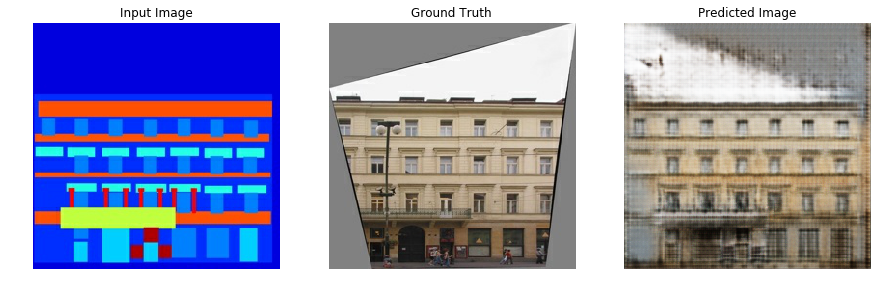

TypeError: __init__() missing 2 required positional arguments: 'message' and 'code'

In [77]:
train(train_dataset, EPOCHS)

## Restore the latest checkpoint and test

In [78]:
# 마지막 체크포인트를 불러들인다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

In [ ]:
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)